In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import warnings 
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
p = matplotlib.rcParams
p["font.size"] = 25
p["axes.unicode_minus"] = False
p['lines.linewidth'] = 3
p['pdf.fonttype'] = 42
p['ps.fonttype'] = 42
p["figure.figsize"] = [12, 12]
p['grid.color'] = 'k'
p['grid.linestyle'] = ':'
p['grid.linewidth'] = 0.5
cmap = plt.get_cmap('viridis')
#colors = cmap(np.linspace(0, 1, n)) #n: number of the lines you want to plot 
import seaborn as sns
sns.set(style="whitegrid")

In [5]:
features = pd.read_csv('spx_cons_norm.csv')
features = features[['tic','datadate','industry_id','forward_excess_ret','ROE','Asset Turnover','EMA6','earningsVol','PS','ev_ebitda']]
industry_dummy = pd.get_dummies(features['industry_id'])
features = pd.merge(features,industry_dummy,how='left',left_index=True,right_index=True)

features = features.dropna(subset=['forward_excess_ret'])
features_after = features.groupby(['tic']).ffill()
features_after = pd.merge(features_after,features[['tic']],how='left',left_index=True,right_index=True)

cols = [col for col in features_after.columns if col not in ['datadate','industry_id','forward_excess_ret','tic']]
df_na = features_after.isnull()

df_mean = features_after.groupby('tic').mean()

In [6]:
for col in cols:
    na_series = features_after[col].isnull()
    names = list(features_after.loc[na_series,'tic'])     

    t = df_mean.loc[names,col]
    t.index = features_after.loc[na_series,col].index

    
    features_after.loc[na_series,col] = t



for col in cols:
    na_series = features_after[col].isnull()
    mean = np.mean(features_after[col]) 
    features_after.loc[na_series,col] = mean

In [7]:
feature_names=['ROE','Asset Turnover','EMA6','earningsVol','PS','ev_ebitda',10,15,20,25,30,35,40,45,50,55,60]
X = features_after[feature_names]
#X = sm.add_constant(X)
Y = features_after[['forward_excess_ret']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=52)

## Prediction

### Linear

In [8]:
#Linear
reg = LassoCV(cv=5,fit_intercept=True,alphas=np.linspace(0.00001,0.001,100)).fit(X_train,y_train)   
print(reg.alphas_)
print(reg.coef_)
print(reg.intercept_)

[1.0e-03 9.9e-04 9.8e-04 9.7e-04 9.6e-04 9.5e-04 9.4e-04 9.3e-04 9.2e-04
 9.1e-04 9.0e-04 8.9e-04 8.8e-04 8.7e-04 8.6e-04 8.5e-04 8.4e-04 8.3e-04
 8.2e-04 8.1e-04 8.0e-04 7.9e-04 7.8e-04 7.7e-04 7.6e-04 7.5e-04 7.4e-04
 7.3e-04 7.2e-04 7.1e-04 7.0e-04 6.9e-04 6.8e-04 6.7e-04 6.6e-04 6.5e-04
 6.4e-04 6.3e-04 6.2e-04 6.1e-04 6.0e-04 5.9e-04 5.8e-04 5.7e-04 5.6e-04
 5.5e-04 5.4e-04 5.3e-04 5.2e-04 5.1e-04 5.0e-04 4.9e-04 4.8e-04 4.7e-04
 4.6e-04 4.5e-04 4.4e-04 4.3e-04 4.2e-04 4.1e-04 4.0e-04 3.9e-04 3.8e-04
 3.7e-04 3.6e-04 3.5e-04 3.4e-04 3.3e-04 3.2e-04 3.1e-04 3.0e-04 2.9e-04
 2.8e-04 2.7e-04 2.6e-04 2.5e-04 2.4e-04 2.3e-04 2.2e-04 2.1e-04 2.0e-04
 1.9e-04 1.8e-04 1.7e-04 1.6e-04 1.5e-04 1.4e-04 1.3e-04 1.2e-04 1.1e-04
 1.0e-04 9.0e-05 8.0e-05 7.0e-05 6.0e-05 5.0e-05 4.0e-05 3.0e-05 2.0e-05
 1.0e-05]
[ 0.00000000e+00  3.31467003e-04 -3.02456003e-04 -0.00000000e+00
 -2.22762116e-05  4.42982067e-04 -4.12440044e-03 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.32483

### KNN

In [15]:
#KNN

for n in [2,3,4,5,6,7,8]:
    neigh = KNeighborsRegressor(n_neighbors=n)
    #neigh.fit(X_train,y_train)
    scores = cross_val_score(neigh, X_train,y_train, cv=5)
    print(n,np.mean(scores))

2 -0.46411379282118287
3 -0.3075805333184049
4 -0.23244345401279856
5 -0.18404651107889558
6 -0.15601523748745355
7 -0.13263829380784106
8 -0.11612589824463396


### Random Forest

In [63]:
#random forest

for max_depth in [2,3,4,5,6,7]:
    regr = RandomForestRegressor(max_depth=max_depth, random_state=0)
    scores = cross_val_score(regr, X_train,y_train, cv=5)
    print(max_depth,np.mean(scores))

2 -5.244963310520045e-05
3 3.706107298195871e-05
4 6.266109790511453e-05
5 -0.0002929393545936687
6 -0.00032736725501354426
7 -0.0010444483953069516


### SVR

In [9]:
#SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline


SVR_m = SVR()
param_grid0 = {'C': [0.01, 0.1], 'epsilon':[0.2,0.3]}
grid_search0 = GridSearchCV(SVR_m, scoring = 'neg_mean_squared_error',param_grid = param_grid0, cv=5, return_train_score=True)

grid_search0.fit(X_train, y_train) 

print("Scores on training set:")
means = grid_search0.cv_results_['mean_test_score']
stds = grid_search0.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search0.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

Scores on training set:
-0.005 (+/-0.000) for {'C': 0.01, 'epsilon': 0.2}
-0.005 (+/-0.000) for {'C': 0.01, 'epsilon': 0.3}
-0.005 (+/-0.000) for {'C': 0.1, 'epsilon': 0.2}
-0.006 (+/-0.000) for {'C': 0.1, 'epsilon': 0.3}


In [48]:
print(grid_search0.cv_results_) 
print(grid_search0.best_params_)

{'mean_fit_time': array([0.91249065, 0.20245285, 1.1305408 , 0.23297019]), 'std_fit_time': array([0.06223298, 0.01649021, 0.08896101, 0.01085212]), 'mean_score_time': array([0.1508935 , 0.03509846, 0.1434238 , 0.03552456]), 'std_score_time': array([0.01474851, 0.00277014, 0.00647697, 0.0053507 ]), 'param_C': masked_array(data=[0.01, 0.01, 0.1, 0.1],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_epsilon': masked_array(data=[0.2, 0.3, 0.2, 0.3],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.01, 'epsilon': 0.2}, {'C': 0.01, 'epsilon': 0.3}, {'C': 0.1, 'epsilon': 0.2}, {'C': 0.1, 'epsilon': 0.3}], 'split0_test_score': array([-0.00470842, -0.00524571, -0.0050708 , -0.00582488]), 'split1_test_score': array([-0.00436114, -0.0048922 , -0.0046925 , -0.00565668]), 'split2_test_score': array([-0.00470296, -0.0054561 , -0.00509059, -0.00611526]), 'split3_test_score': ar

In [10]:
SVR_f = grid_search0.best_estimator_.fit(X_train, y_train)

y_hat0 = SVR_f.predict(X_test)
svm_score = SVR_f.score(X_test, y_test)
svm_score

-0.02134275265783958

### Decision Tree

In [6]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=0)

param_grid2 = {"criterion" : ["mse"],
              "max_depth" :   [2,3,4],
               'min_samples_split' : [2,5,10]
             }

grid_search3 = GridSearchCV(tree, param_grid=param_grid2,scoring='neg_mean_squared_error', cv=5, return_train_score = True)
grid_search3.fit(X_train, y_train) 

print("Scores on training set:")
means = grid_search3.cv_results_['mean_test_score']
stds = grid_search3.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search3.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print(grid_search3.best_params_)

Scores on training set:
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 2}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 5}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 10}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 3, 'min_samples_split': 2}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 3, 'min_samples_split': 5}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 3, 'min_samples_split': 10}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 4, 'min_samples_split': 2}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 4, 'min_samples_split': 5}
-0.004 (+/-0.000) for {'criterion': 'mse', 'max_depth': 4, 'min_samples_split': 10}
{'criterion': 'mse', 'max_depth': 2, 'min_samples_split': 10}


In [18]:
print(grid_search3.cv_results_) 
print(grid_search3.best_params_)

{'mean_fit_time': array([0.07203465, 0.07299223, 0.08360324, 0.1038518 , 0.10670652,
       0.10372281, 0.12428365, 0.12995954, 0.12748337]), 'std_fit_time': array([0.00799288, 0.00546438, 0.00537211, 0.00773252, 0.00992754,
       0.0072094 , 0.00739064, 0.00847092, 0.00248132]), 'mean_score_time': array([0.00517912, 0.00560379, 0.00678177, 0.00488887, 0.00518675,
       0.00539322, 0.00499339, 0.00439467, 0.0050014 ]), 'std_score_time': array([0.00116468, 0.00161287, 0.00098472, 0.00065536, 0.00097793,
       0.00134439, 0.00089993, 0.00079397, 0.00108717]), 'param_criterion': masked_array(data=['mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse',
                   'mse'],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 4, 4, 4],
             mask=[False, False, False, False, False, False, False, False,
                   

In [7]:
DT = grid_search3.best_estimator_.fit(X_train, y_train)

y_hat1 = DT.predict(X_test)
DT_score = DT.score(X_test, y_test)
DT_score

-0.006309954768688897

### Investigating the predictions

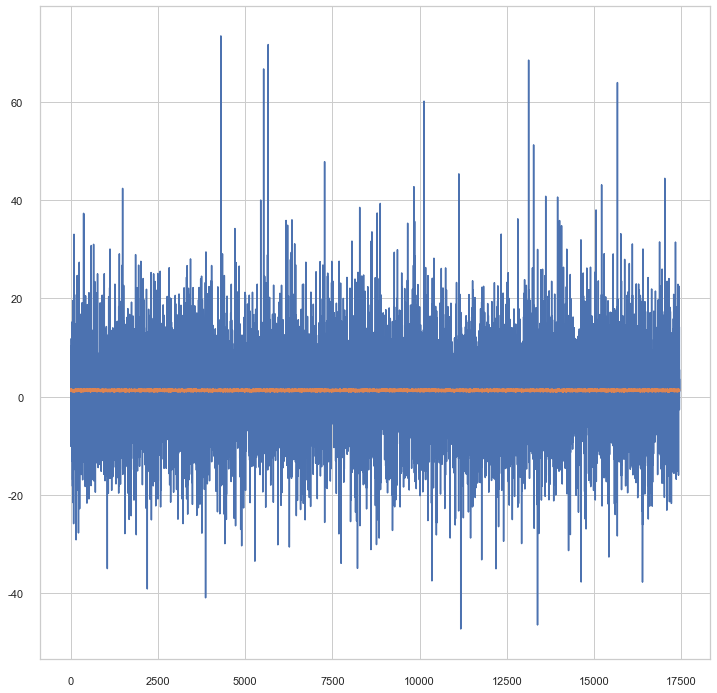

In [20]:
plt.plot(y_test.values.ravel())
plt.plot(y_hat0)

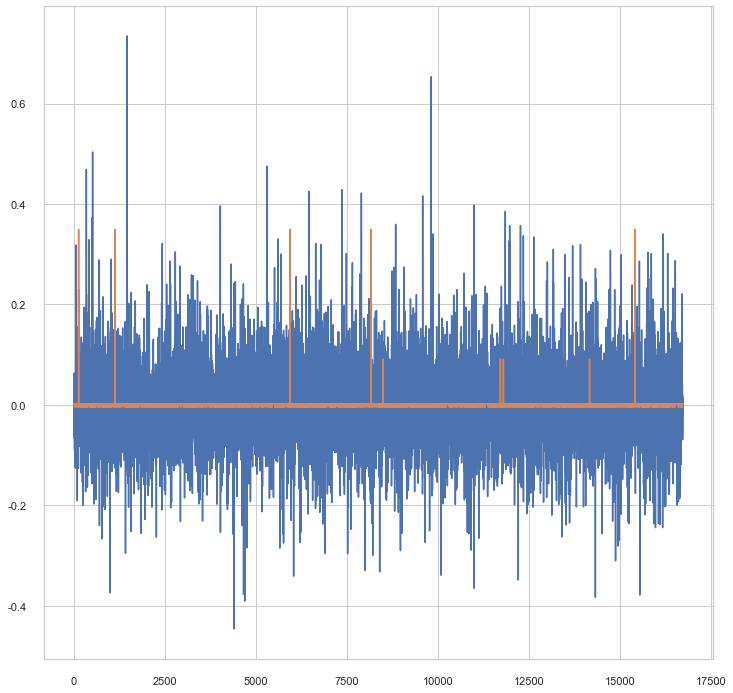

In [67]:
plt.plot(y_test.values.ravel())
plt.plot(y_hat1)

## Intertability

### Partial Dependance Plot

PDP shows the marginal effect one or two features have on the predicted outcome of a machine learning model.

For example, when applied to the LASSO model, PDP always show linear relationships. The relationships for other models can be more complex.

One-way PDPs tell us about the interaction between the target response and the target feature (e.g. linear, non-linear). 

PDPs with two target features show the interactions among the two features.

(y -= y.mean(). This subtracts the mean target value from our target vector and centres our target variables to 0; as a result our PDPs values will be centred approximately around 0 too. )

In [68]:
regr.fit(X_train,y_train)
print(sorted(zip(map(lambda x: round(x, 4), regr.feature_importances_), feature_names[:6]), reverse=True))

[(0.2143, 'EMA6'), (0.2024, 'ROE'), (0.157, 'ev_ebitda'), (0.1309, 'Asset Turnover'), (0.1057, 'PS'), (0.1026, 'earningsVol')]


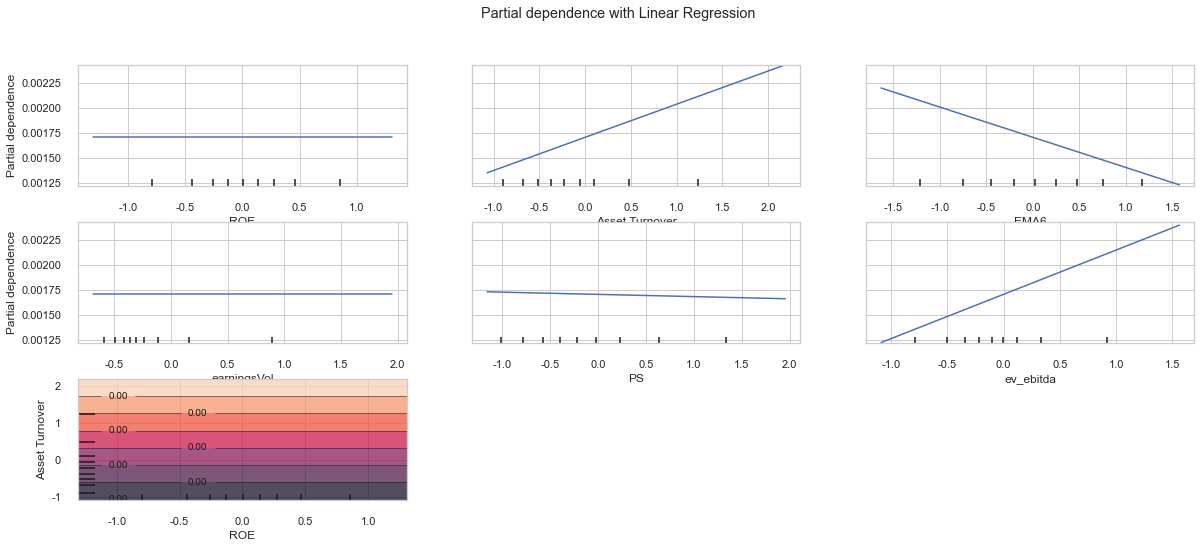

In [73]:
from sklearn.datasets import make_hastie_10_2
from sklearn.inspection import plot_partial_dependence
from matplotlib import pyplot as plt
feature_names=['ROE','Asset Turnover','EMA6','earningsVol','PS','ev_ebitda',10,15,20,25,30,35,40,45,50,55,60]

features = list(range(6))
features.append((0,1))

plot_partial_dependence(reg, X_train, features, feature_names=feature_names[:6]) 
fig = plt.gcf()
fig.suptitle('Partial dependence with Linear Regression')
fig.subplots_adjust(hspace=0.3)

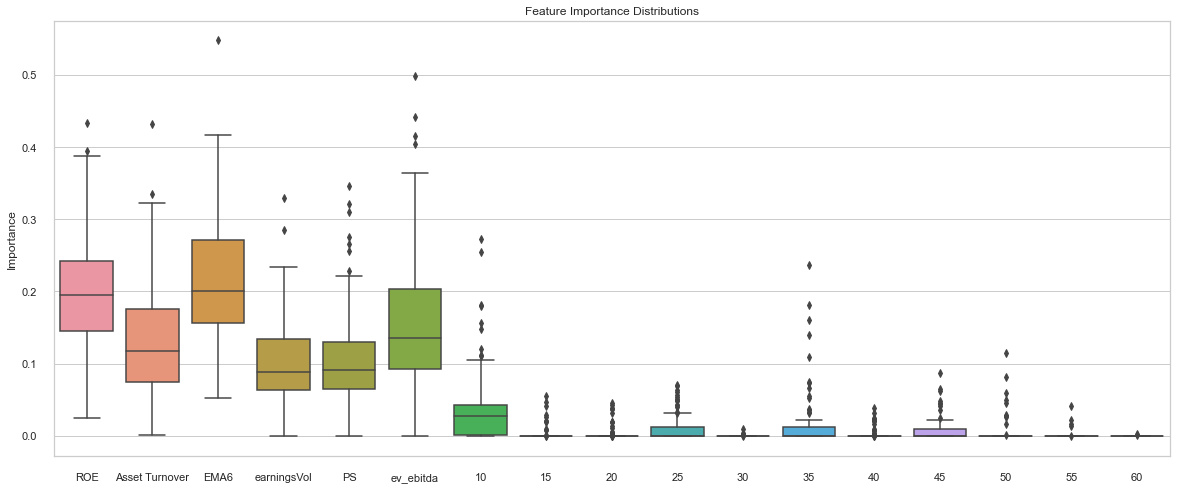

In [69]:
import seaborn as sns
p["figure.figsize"] = [20, 8]
# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     regr],
                               columns=feature_names)

(sns.boxplot(data=all_feat_imp_df)
        .set(title='Feature Importance Distributions',
             ylabel='Importance'));

### Feature Importance

Permutation feature importance measures the increase in the prediction error of the model after we permuted the feature's values.

It basically includes three steps:

(1) Train the models and estimate the original model error E0 (e.g. MSE).

(2) For each feature, generate feature matrix by permuting feature j, then estimate the error E1 based on the predictions of the permuted data. Then Calculate the permutation feature importance FI = E1/E0 or FI = E1-E0

(3) Sort the features by descending FI.

#### Mean Decrease Impurity

By default the show_weights method uses gain to calculate the weight but you can specify other types by adding the importance_type argument.

You can also use show_prediction to inspect the reasons for individual predictions.

In [70]:
import eli5
from eli5.sklearn import PermutationImportance
feat_imp_df = eli5.explain_weights_df(reg, feature_names=feature_names)
feat_imp_df

target         feature    weight
0      y              45  0.002327
1      y          <BIAS>  0.001575
2      y              35  0.001325
3      y       ev_ebitda  0.000443
4      y  Asset Turnover  0.000331
5      y              PS -0.000022
6      y            EMA6 -0.000302
7      y              10 -0.004124

#### Permutation Importance

In [71]:
perm = PermutationImportance(reg, random_state=1).fit(X_test, y_test)
#feature_names = feature_names.astype(str)
for i in range(0, len(feature_names)): 
    feature_names[i] = str(feature_names[i]) 
      
eli5.show_weights(perm, feature_names = feature_names)

[(0.2143, 'EMA6'), (0.2024, 'ROE'), (0.157, 'ev_ebitda'), (0.1309, 'Asset Turnover'), (0.1057, 'PS'), (0.1026, 'earningsVol')]


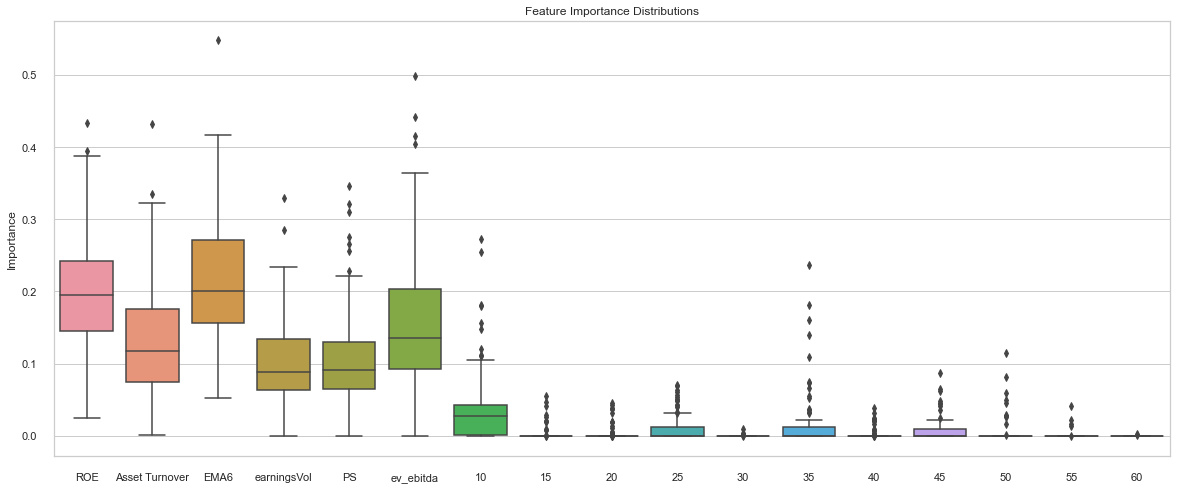

In [72]:
regr.fit(X_train,y_train)
print(sorted(zip(map(lambda x: round(x, 4), regr.feature_importances_), feature_names[:6]), reverse=True))
import seaborn as sns
# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     regr],
                               columns=feature_names)

(sns.boxplot(data=all_feat_imp_df)
        .set(title='Feature Importance Distributions',
             ylabel='Importance'));

### ICE(Individual Conditional Expectation)

The PDP does not focus on specific instances, but on an overall average. An ICE plot visualizes the dependence of the prediction on a feature for each instance separately, resulting in one line per instance, compared to one line overall in PDP.

Pros: 
- ICE is more intuitive to understand than PDP. One line represents the predictions for one instance if we vary the feature of interest.
- ICE can uncover heterogeneous relationships.

Cons:
- ICE can only display one feature meaningfully.
- Not easy to see the average.


##### One Problem with pycebox.ice:
memoryError!

In [ ]:
from pycebox.ice import ice, ice_plot
ROE_ice_df = ice(data=X_train, column='ROE', predict=reg.predict)
ice_plot(ROE_ice_df, c='dimgray', linewidth=0.3)
plt.ylabel('Pred. AV %ile')
plt.xlabel('ROE')##### One Problem with pycebox.ice:
memoryError

### SHAP
- A prediction can be explained by assuming that each feature value of the instance is a "player" in a game where the prediction is the payout. Shapley values -- a method from coalitional game theory -- tells us how to fairly distribute the "payout" among the features. The Shapley value is the **average marginal contribution of a feature value across all possible coalitions**.  


- SHAP (SHapley Additive exPlanations) by Lundberg and Lee (2016)44 is a method to explain individual predictions. SHAP is based on the game theoretically optimal **Shapley Values**. The goal of SHAP is to explain the prediction of an instance x by computing the **contribution of each feature to the prediction**. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the "payout" (= the prediction) among the features. 

##### SHAP Summary Plot
- To get an overview of **which features** are **most important for a model** we can **plot** the **SHAP values** of **every feature** for **every sample**. 


- We use a **density scatter plot** of **SHAP values** for **each feature to identify** how much **impact each feature has on the model output** for **individuals** in the **validation dataset**. 


- **Features** are **sorted** by the **sum of the SHAP value magnitudes** across all samples. 


- Note that when the **scatter points don't fit on a line** they **pile up to show density**, and the **color of each point represents** the **feature value of that individual**.

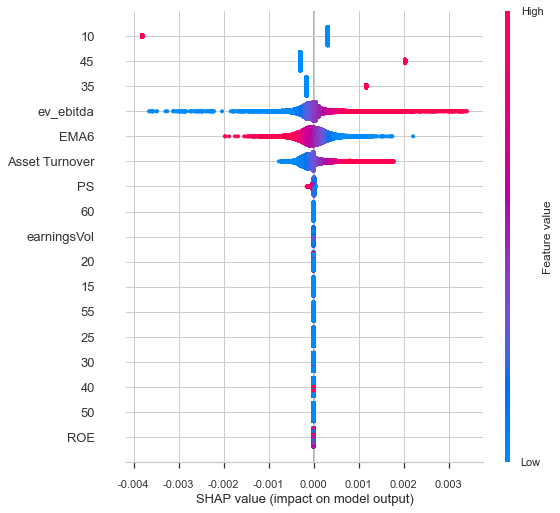

In [11]:
import shap
shap.initjs()
explainer = shap.LinearExplainer(reg,X_train)
shap_values = explainer.shap_values(X_train.values)
shap.summary_plot(shap_values, X_train)

- The **plot** above **sorts features** by the **sum of SHAP value magnitudes over all samples**, and **uses SHAP values** to show the **distribution of the impacts each feature has on the model output**. 


- The **color represents the feature value (red high, blue low)**. 


- This **reveals** for example that a **high EMA6** **lowers the forward excess return**.

##### Bar chart of Mean Importance
This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

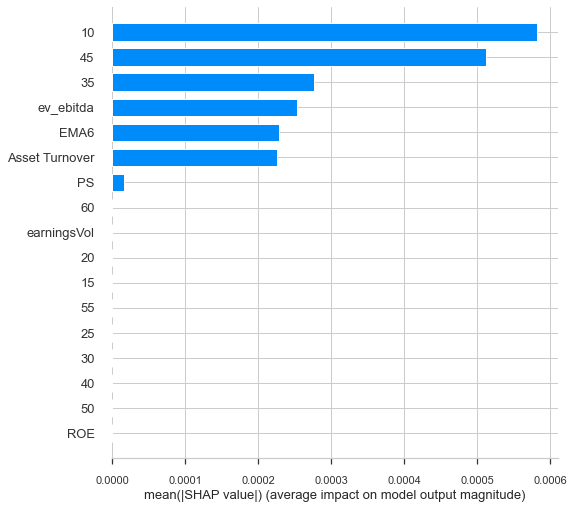

               var  feature_importances_
6               10              0.000582
13              45              0.000512
11              35              0.000276
5        ev_ebitda              0.000254
2             EMA6              0.000229
1   Asset Turnover              0.000227
4               PS              0.000016
0              ROE              0.000000
15              55              0.000000
14              50              0.000000
12              40              0.000000
8               20              0.000000
10              30              0.000000
9               25              0.000000
7               15              0.000000
3      earningsVol              0.000000
16              60              0.000000


In [12]:
shap.summary_plot(shap_values, X_train, plot_type="bar")
global_shap_values_1 = pd.DataFrame(np.abs(shap_values).mean(0),index=X_train.columns).reset_index()
global_shap_values_1.columns = ['var','feature_importances_']
global_shap_values_1 = global_shap_values_1.sort_values('feature_importances_',ascending=False)
print(global_shap_values_1)

- Here we can see that the **ev_ebitda** column has the **highest feature importance** followed by **EMA6** column (without looking at dummy variables).

- This implies that the **ev_ebitda** and **EMA6** have the **highest** effect on the **forward excess return**.

##### Dependence Plots
- **SHAP dependence plots** show the **effect of a single feature across the whole dataset**. 

- They **plot a feature's value vs. the SHAP value** of that feature **across many samples**.

- The **vertical dispersion** of **SHAP values at a single feature value** is driven by **interaction effects**, and **another feature** is chosen for **coloring** to **highlight possible interactions**.

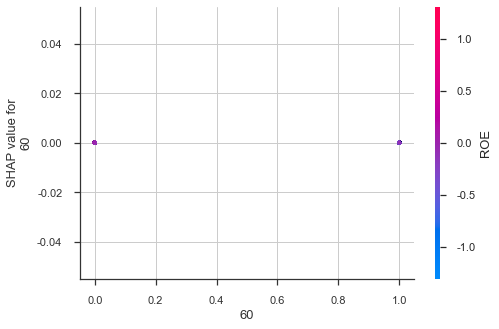

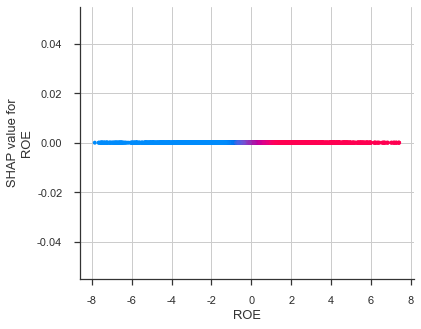

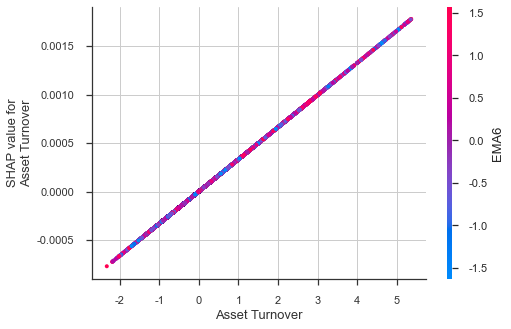

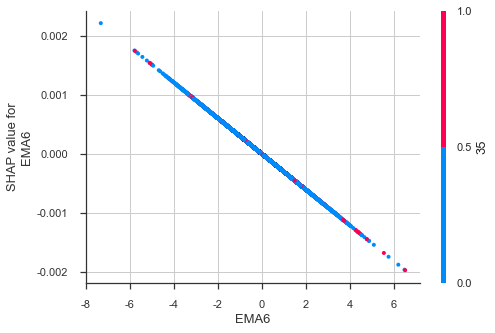

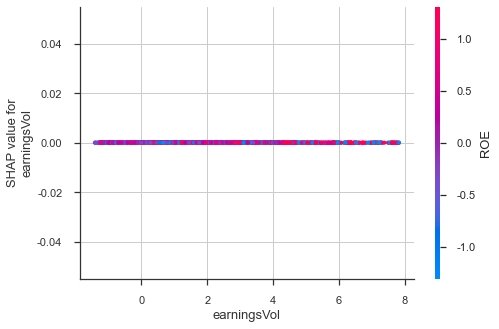

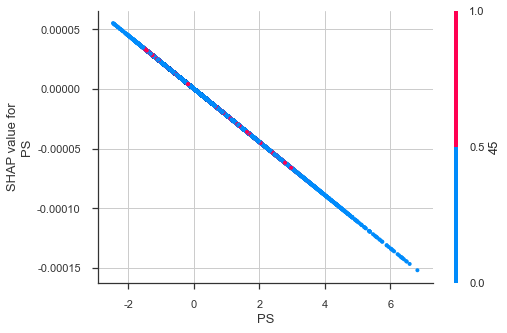

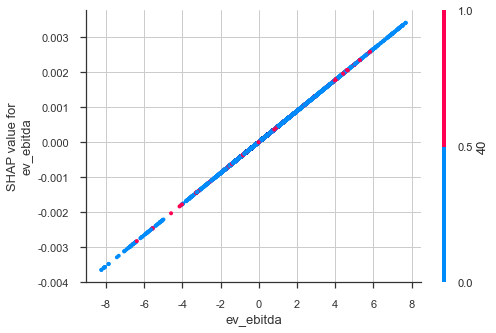

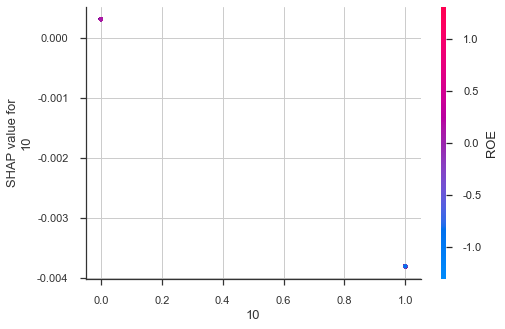

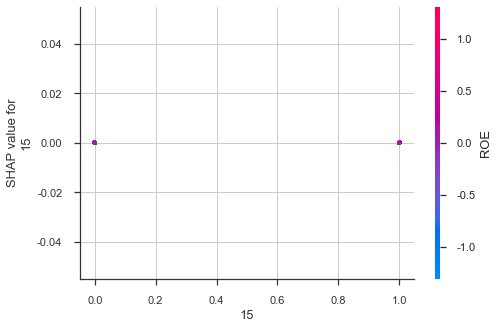

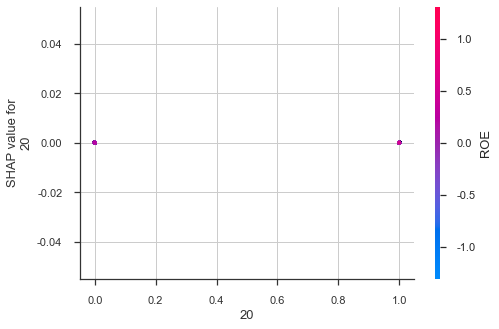

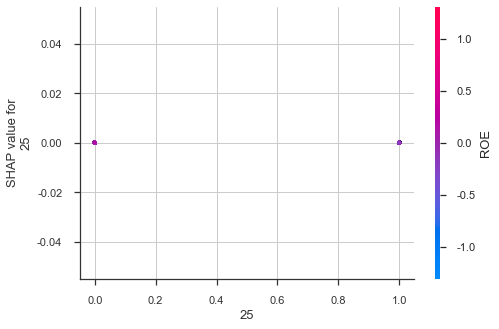

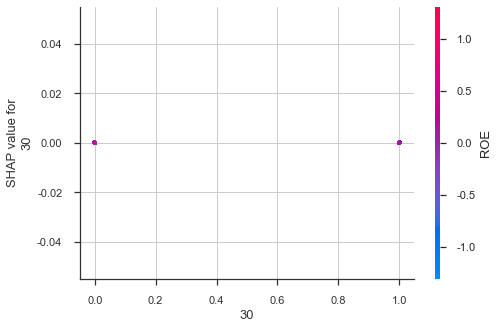

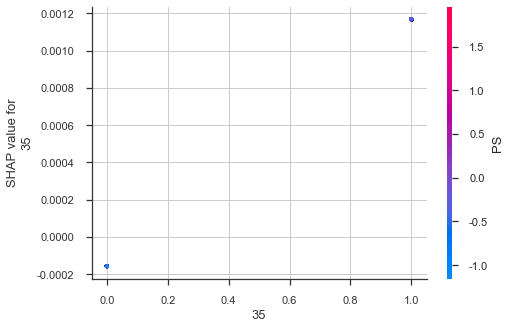

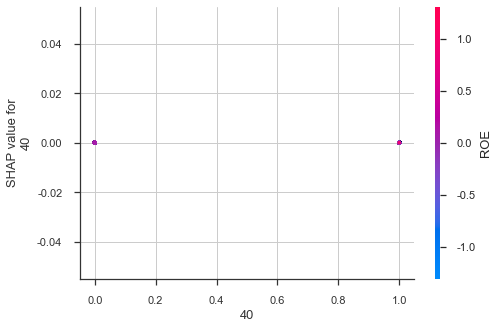

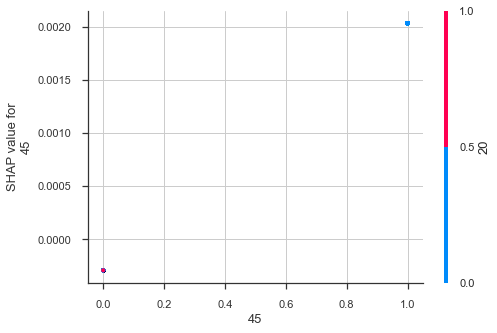

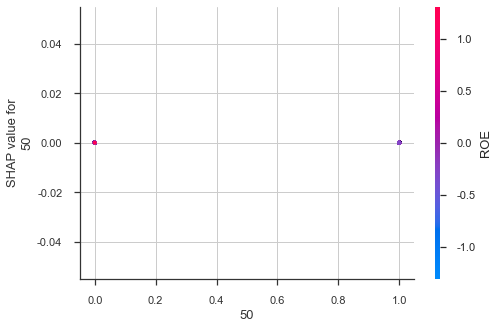

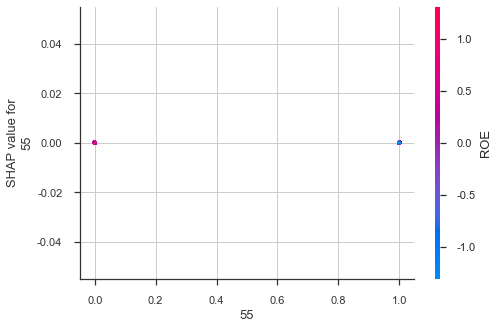

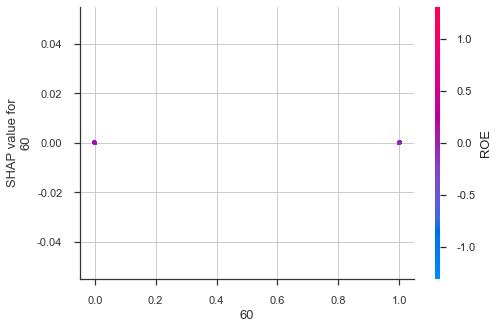

In [10]:
#dependence plots

shap.dependence_plot(16, shap_values, X_train)

for i in range(17):
#    print(i)
    shap.dependence_plot(i, shap_values, X_train)

- This shows us the method for **Plotting** the **Dependence Plots** for **each feature** in the dataset in a few lines of code.

### Global Surrogate

A global surrogate model is an interpretable model that is trained to approximate the predictions of a black box model. We can draw conclusions about the black box model by interpreting the surrogate model. 

Note: I double-checked the package only to find that this interpret-community package is under alpha-release maintain and there is no MimicExplainer for current version. Please pip install interpret-community==0.14.4

In [12]:
from interpret.ext.blackbox import MimicExplainer
from interpret.ext.glassbox import LinearExplainableModel

SVR_fit = grid_search0.fit(X_train, y_train) 

explainer = MimicExplainer(SVR_fit,
                           X_train,
                           LinearExplainableModel,
                           augment_data=False,
                           features=feature_names)

global_explanation = explainer.explain_global(X_test)

global_explanation.visualize()

Here a Linear Explainable Model, the LASSO regression, is employed to explain the black box model, SVR, as a surrogate. So we should explain the result on LASSO regression. We can see that the value of the orange bar represents the lasso regression parameter value of the feature. To explain the features, for example, when the industry 25 is considered, the predicted forward excess return will be 0.11% higher, given all other features remain fixed.

One way to measure how well the surrogate replicates the black box model is the R-squared measure: <br>
$ R^2=1-\frac{SSE}{SST}=1-\frac{\sum_{i=1}^n(\hat{y}_*^{(i)}-\hat{y}^{(i)})^2}{\sum_{i=1}^n(\hat{y}^{(i)}-\bar{\hat{y}})^2} $ <br>
If R-squared is close to 1 (= low SSE), then the interpretable model approximates the behavior of the black box model very well. If the interpretable model is very close, you might want to replace the complex model with the interpretable model. If the R-squared is close to 0 (= high SSE), then the interpretable model fails to explain the black box model.

In [14]:
y_hat_LASSO = reg.predict(X_test)

print("R square:", 1-sum((y_hat_LASSO-y_hat0)**2)/sum((y_hat0-np.mean(y_hat0))**2))

R square: -0.6623421484876622


We can see the R square is below 0, which means the LASSO regression is even beaten by the mean value estimation. Hence, the LASSO regression is not a good surrogate for SVR. And we need to try other surrogates to pick the one with the lowest R square.

#### Generate global explanations
Explain overall model predictions (global explanation)

In [52]:
# Passing in test dataset for evaluation examples - note it must be a representative sample of the original data
# x_train can be passed as well, but with more examples explanations will take longer although they may be more accurate
global_explanation = explainer.explain_global(X_test)

# Note: if you used the PFIExplainer in the previous step, use the next line of code instead
# global_explanation = explainer.explain_global(x_test, true_labels=y_test)

In [53]:
# Sorted SHAP values 
print('ranked global importance values: {}'.format(global_explanation.get_ranked_global_values()))
# Corresponding feature names
print('ranked global importance names: {}'.format(global_explanation.get_ranked_global_names()))
# Feature ranks (based on original order of features)
print('global importance rank: {}'.format(global_explanation.global_importance_rank))

ranked global importance values: [0.0028362282874271746, 0.0011666939099345595, 0.00113559343395028, 0.0009451915731473848, 0.0009390005129362407, 0.0005841121506098883, 0.0005085209600636916, 0.00043310026885446046, 0.0002763152330350669, 0.0002156375989631428, 0.0001614916855517768, 0.000157320058453201, 8.970035061659976e-05, 6.269537066566919e-05, 2.2445918481767645e-05, 1.9782002373270916e-05, 1.3272659412919138e-05]
ranked global importance names: ['EMA6', 'ROE', 25, 'PS', 'Asset Turnover', 'earningsVol', 45, 40, 'ev_ebitda', 15, 55, 35, 20, 50, 60, 30, 10]
global importance rank: [2, 0, 9, 4, 1, 3, 13, 12, 5, 7, 15, 11, 8, 14, 16, 10, 6]


In [54]:
# Print out a dictionary that holds the sorted feature importance names and values
print('global importance rank: {}'.format(global_explanation.get_feature_importance_dict()))

global importance rank: {'EMA6': 0.0028362282874271746, 'ROE': 0.0011666939099345595, 25: 0.00113559343395028, 'PS': 0.0009451915731473848, 'Asset Turnover': 0.0009390005129362407, 'earningsVol': 0.0005841121506098883, 45: 0.0005085209600636916, 40: 0.00043310026885446046, 'ev_ebitda': 0.0002763152330350669, 15: 0.0002156375989631428, 55: 0.0001614916855517768, 35: 0.000157320058453201, 20: 8.970035061659976e-05, 50: 6.269537066566919e-05, 60: 2.2445918481767645e-05, 30: 1.9782002373270916e-05, 10: 1.3272659412919138e-05}


Let's try a Decision Tree surrogate.

In [ ]:
from interpret.ext.glassbox import DecisionTreeExplainableModel

explainer2 = MimicExplainer(SVR_fit,
                           X_train,
                           DecisionTreeExplainableModel,
                           augment_data=False,
                           features=feature_names)

global_explanation = explainer2.explain_global(X_test)

global_explanation.visualize()

In [ ]:
print("R square:", 1-sum((y_hat1-y_hat0)**2)/sum((y_hat0-np.mean(y_hat0))**2))

### Local Interpretable Model-Agnostic Explanations(LIME)

Unlike Global Surrogate, LIME generates a new dataset consisting of permuted samples and the corresponding predictions of the black box model. On this new dataset LIME then trains an interpretable model, which is weighted by the proximity of the sampled instances to the instance of interest. For regressions, it is easier to interpret categorical features than numerical features. One solution is to categorize the numerical features into bins.

In [15]:
# numerical to categorical
categorical_features = range(6 ,17)

In [16]:
import lime
import lime.lime_tabular

#### Create the explainer

As opposed to lime_text.TextExplainer, tabular explainers need a training set. The reason for this is because we compute statistics on each feature (column). If the feature is numerical, we compute the mean and std, and discretize it into quartiles. If the feature is categorical, we compute the frequency of each value. 

We use these computed statistics for two things:

1. To scale the data, so that we can meaningfully compute distances when the attributes are not on the same scale 
2. To sample perturbed instances - which we do by sampling from a Normal(0,1), multiplying by the std and adding back the mean.

There are two tricks which we need to be careful with. Firstly, the selection of the instance of interest, and secondly the best kernel width. After the categorical transformation, it is better to select the instance of interest near the classification boundary of the original black box model. Here, we look at the 25th sample on the original data set and use the default kernel width, which is 3. Meanwhile, we still apply a LASSO regression as a local surrogate.

In [17]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=feature_names, class_names=['price'], categorical_features=categorical_features, kernel_width=3, verbose=True, mode='regression')

In [18]:
i = 25 # can search for the mass center
exp_lime = explainer_lime.explain_instance(X_test.values[i], grid_search0.predict, num_features=5)

Intercept 0.009407644149894019
Prediction_local [0.00534081]
Right: 0.0014035898279834789


In [21]:
exp_lime.show_in_notebook(show_table=True, show_all=False)

In [173]:
exp_lime.as_list()

[('ROE > 0.36', -0.006222451367668174),
 ('25=0', 0.0051249592767529705),
 ('Asset Turnover > 0.25', 0.0037351413740451356),
 ('-0.59 < EMA6 <= 0.02', -0.0031726383422988995),
 ('PS <= -0.67', 0.002885029284827449)]

In [23]:
X_test.values[i]

array([ 0.91279701,  0.40971019, -0.08917746, -0.20622982, -1.10005865,
       -0.89224348,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

#### Explaining predictions
The features selected by LASSO are listed on the right table by the order of feature importance. The value column shows the value of the 25th sample on each selected features, which is why we call it a local surrogate. The middle plot demonstrate the marginal contribution of those selected features. For example, when ROE is bigger than 0.36, the forward excess return will decrease by 0.62%, given other features fixed. Finally, the plot on the left indicates the variation scale of the forward excess return around the 25th data point, which is from -2% to 4%.


Let's try a different kernel_width, say 0.3.

In [36]:
explainer_lime2 = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=feature_names, class_names=['price'], categorical_features=categorical_features, kernel_width=0.3, verbose=True, mode='regression')

In [37]:
i = 25
exp_lime2 = explainer_lime2.explain_instance(X_test.values[i], grid_search0.predict, num_features=5)

Intercept 0.0014658209878781392
Prediction_local [0.00143409]
Right: 0.0014035898279834789


In [38]:
exp_lime2.show_in_notebook(show_table=True)

In [39]:
exp_lime2.as_list()

[('-0.59 < EMA6 <= 0.02', -4.471308588828091e-05),
 ('PS <= -0.67', 1.4660359171155383e-05),
 ('ROE > 0.36', -9.725303234590988e-07),
 ('ev_ebitda <= -0.42', -5.136198971551337e-07),
 ('Asset Turnover > 0.25', -1.915170038874991e-07)]

This time we can see the dummies are no longer selected, while 5 factors have little impact on the excess return forcast. We can find different kernel_width have different results. Unfortunately, at present we can only adjust the kernel width manually according to the economic intuition and the direction of change. It is a future research to find a systematic method to adjust the parameters.